In [1]:
import pandas as pd
data = pd.read_csv('insample.csv')
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
import numpy as np
zscore = lambda x: (x - x.mean()) / x.std()

In [2]:
data_dict = {}
for year in range(1980,2009):
    data_dict[year]=data.query("year=="+str(year))

In [3]:
all_factor_name = ['CAPEI',
 'bm',
 'evm',
 'pe_op_basic',
 'pe_op_dil',
 'pe_exi',
 'pe_inc',
 'ps',
 'pcf',
 'dpr',
 'npm',
 'opmbd',
 'opmad',
 'gpm',
 'ptpm',
 'cfm',
 'roa',
 'roe',
 'roce',
 'efftax',
 'aftret_eq',
 'aftret_invcapx',
 'aftret_equity',
 'pretret_noa',
 'pretret_earnat',
 'GProf',
 'equity_invcap',
 'debt_invcap',
 'totdebt_invcap',
 'capital_ratio',
 'int_debt',
 'int_totdebt',
 'cash_lt',
 'invt_act',
 'rect_act',
 'debt_at',
 'debt_ebitda',
 'short_debt',
 'curr_debt',
 'lt_debt',
 'profit_lct',
 'ocf_lct',
 'cash_debt',
 'fcf_ocf',
 'lt_ppent',
 'dltt_be',
 'debt_assets',
 'debt_capital',
 'de_ratio',
 'intcov',
 'intcov_ratio',
 'cash_ratio',
 'quick_ratio',
 'curr_ratio',
 'cash_conversion',
 'inv_turn',
 'at_turn',
 'rect_turn',
 'pay_turn',
 'sale_invcap',
 'sale_equity',
 'sale_nwc',
 'rd_sale',
 'adv_sale',
 'staff_sale',
 'accrual',
 'ptb',
 'PEG_trailing',
 'DIVYIELD',
 'PEG_1yrforward',
 'PEG_ltgforward',
 'alpha',
 'b_mkt',
 'b_smb',
 'b_hml',
 'b_umd',
 'ivol',
 'tvol',
 'R2',
 'exret',
 'Tbi',
 'OPA',
 'Sp',
 'IG',
 'IK',
 'Rds',
 'Adm',
 'dp']

CAPEI
bm
evm
pe_op_basic
pe_op_dil
pe_exi
pe_inc
ps
pcf
dpr
npm
opmbd
opmad
gpm
ptpm
cfm
roa
roe
roce
efftax
aftret_eq
aftret_invcapx
aftret_equity
pretret_noa
pretret_earnat
GProf
equity_invcap
debt_invcap
totdebt_invcap
capital_ratio
int_debt
int_totdebt
cash_lt
invt_act
rect_act
debt_at
debt_ebitda
short_debt
curr_debt
lt_debt
profit_lct
ocf_lct
cash_debt
fcf_ocf
lt_ppent
dltt_be
debt_assets
debt_capital
de_ratio
intcov
intcov_ratio
cash_ratio
quick_ratio
curr_ratio
cash_conversion
inv_turn
at_turn
rect_turn
pay_turn
sale_invcap
sale_equity
sale_nwc
rd_sale
adv_sale
staff_sale
accrual
ptb
PEG_trailing
DIVYIELD
PEG_1yrforward
PEG_ltgforward
alpha
b_mkt
b_smb
b_hml
b_umd
ivol
tvol
R2
exret
Tbi
OPA
Sp
IG
IK
Rds
Adm
dp


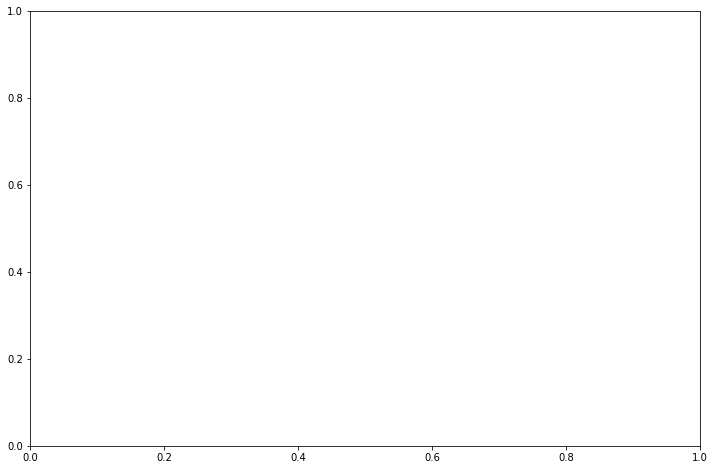

In [4]:
# Long/Short top/bottom 10%
# You can choose to use the same method for finding alphas

start = 1980
end = 2008
result_list = []
for factor_name in all_factor_name:
    print(factor_name)
    returndata = np.zeros(len(range(start,end)))
    valid_n = np.zeros(len(range(start,end)))
    for year in range(start,end):
        
        temp = data_dict[year][['permno','ret1yrafter','INDUSTRY',factor_name]]
        temp = temp[temp[factor_name].notna()]
        bound1 = temp[factor_name].mean() - 3* temp[factor_name].std()
        bound2 = temp[factor_name].mean() + 3* temp[factor_name].std()
        temp = temp[temp[factor_name].between(bound1, bound2)]
        temp['zscore']=temp.groupby(['INDUSTRY'])[factor_name].transform(zscore)
        temp = temp[temp['zscore'].notna()]
        temp.sort_values(by='zscore',inplace = True)
        
        total = temp.shape[0]
        count = int(total*0.1)
        short= temp.head(count)
        long = temp.tail(count)
        long_return = long['ret1yrafter'].sum()/count
        short_return = short['ret1yrafter'].sum()/count
        if not (np.isnan(long_return) and np.isnan(short_return)):
            returndata[year-start] = long_return-short_return
        else:
            returndata[year-start] = 0
        valid_n[year-start] = total
    t_statistics, p_value = stats.ttest_1samp(returndata,0)
    if np.isnan(t_statistics):
        t_statistics = -999
        p_value = -999
    str_t_statistics = "%.3f"%t_statistics
    str_p_value = "%.3f"%p_value
    str_valid_n = '%.1f'%np.mean(valid_n)
    a = pd.DataFrame(returndata,index = range(start,end), columns = ['return'])
    a['Profit'] = a.cumsum()*100
    chart = a['Profit'].plot(grid=True,figsize=[12,8],linewidth=1,color='darkorange', title= factor_name+' ----- '+'t-stat: '+str_t_statistics+'; p-value: '+str_p_value+'; average_valid_count: '+str_valid_n)
    chart.get_figure().savefig('./Charts/'+factor_name+'.png')
    chart.clear()
    result_list.append((factor_name,str_t_statistics,str_p_value,str_valid_n))

pd.DataFrame(result_list, columns = ['factor','t-stat', 'p-value','average obs']).to_csv('./Charts/result.csv')